# Работа с текстом

В этом домашнем задании вам предстоит поработать с текстовыми данными и научиться находить спам сообщения!

In [ ]:
import inspect
import math
import random
import re
from collections import Counter, defaultdict
from string import punctuation

import numpy as np
from tqdm import tqdm
from nltk import SnowballStemmer, download
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


SEED = 0xC0FFEE
set_seed(SEED)

In [ ]:
def read_dataset(filename):
    x, y = [], []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cl, sms = re.split(r"^(ham|spam)[\t\s]+(.*)$", line)[1:3]
            x.append(sms)
            y.append(cl)
    return x, y

In [ ]:
X, y = read_dataset("spam.txt")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=SEED, stratify=y)

In [ ]:
for x_, y_ in zip(X_train[:5], y_train[:5]):
    print(f"{y_}: {x_}")

ham: Two fundamentals of cool life: "Walk, like you are the KING"...! OR "Walk like you Dont care,whoever is the KING"!... Gud nyt
ham: Haha... Where got so fast lose weight, thk muz go 4 a month den got effect... Gee,later we go aust put bk e weight.
ham: I wish things were different. I wonder when i will be able to show you how much i value you. Pls continue the brisk walks no drugs without askin me please and find things to laugh about. I love you dearly.
ham: Tmr then ü brin lar... Aiya later i come n c lar... Mayb ü neva set properly ü got da help sheet wif ü...
ham: For many things its an antibiotic and it can be used for chest abdomen and gynae infections even bone infections.


In [ ]:
Counter(y_train)

Counter({'ham': 4344, 'spam': 672})

In [ ]:
def visualize_words_frequency(text: list[str], vectoriser) -> None:
    tokens = []
    for sentence in text:
        tokens.extend(vectoriser._tokenize(sentence))

    word_counts = Counter(tokens)
    sorted_counts = sorted(word_counts.values(), reverse=True)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(sorted_counts)+1), sorted_counts, 'b-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Word rank")
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of words")
    plt.grid(True)
    plt.show()

In [ ]:
def find_optimal_vocab_size(X_train, y_train, X_test, y_test, vectorizer, classifier, vocab_range):
    results = []
    best_score = 0
    best_size = None

    for size in tqdm(vocab_range):
        vect = vectorizer(vocabulary_size=size)

        X_train_vec = vect.fit_transform(X_train)
        X_test_vec = vect.transform(X_test)

        classifier.fit(X_train_vec, y_train)

        y_pred = classifier.predict(X_test_vec)
        score = accuracy_score(y_test, y_pred)

        results.append((size, score))

        if score > best_score:
            best_score = score
            best_size = size

    return {
        'best_size': best_size,
        'best_score': best_score,
        'results': results
    }

## Bag of Words (2 балла)

Реализуйте простой подсчет слов в тексте, в качестве токенизатора делите по пробелу, убрав перед этим все знаки пунктуации и приведя к нижнему регистру.

После этого обучите простую логистическую модель, измерьте ее качество и сделайте выводы.

In [ ]:
class BagOfWords:
    def __init__(self, vocabulary_size: int = 1000):
        """Init Bag-of-Words instance

        Args:
            vocabulary_size: maximum number of tokens in vocabulary
        """
        self._vocabulary_size = vocabulary_size
        self._vocabulary: dict[str, int] = None

    def _tokenize(self, sentence: str) -> list[str]:
        sentence = re.sub(r'[^\w\s]', '', sentence.lower())
        return sentence.split()

    def fit(self, sentences: list[str]):
        """Fit Bag-of-Words based on list of sentences"""
        word_counts = Counter()

        for sentence in sentences:
            tokens = self._tokenize(sentence)
            word_counts.update(tokens)

        sorted_words = word_counts.most_common(self._vocabulary_size)

        self._vocabulary = {word: i for i, (word, _) in enumerate(sorted_words)}

    def transform(self, sentences: list[str]) -> np.ndarray:
        """Vectorize texts using built vocabulary

        Args:
            sentences: list of sentences to vectorize

        Return:
            transformed texts, matrix of (n_sentences, vocab_size)
        """
        if self._vocabulary is None:
            raise RuntimeError("Fit before transforming!")

        vectors = np.zeros((len(sentences), self._vocabulary_size))

        for i, sentence in enumerate(sentences):
            tokens = self._tokenize(sentence)
            for token in tokens:
                if token in self._vocabulary:
                    vectors[i, self._vocabulary[token]] += 1

        return vectors


    def fit_transform(self, sentences: list[str]) -> np.ndarray:
        self.fit(sentences)
        return self.transform(sentences)

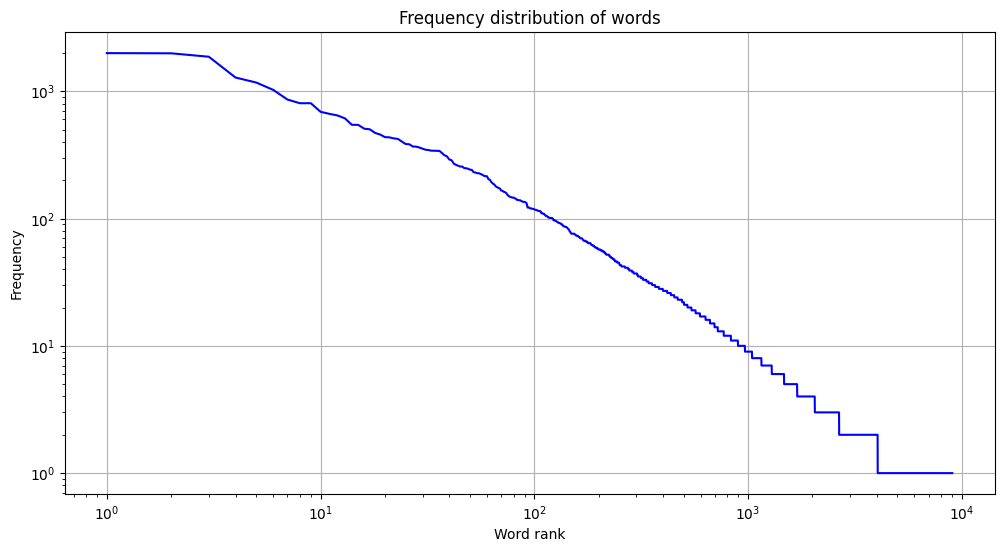

In [ ]:
visualize_words_frequency(X_train, BagOfWords())

По графику видно, что слова, ранг которых больше 4000, встречаются всего 1 раз. Существенный скачок частоты слов происходит примерно на 500 слове и далее начинается всё более выраженная "лесенка". Поэтому для выбора оптимального размера словаря можно рассматривать интервал от 400 до 800.

In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, BagOfWords, LogisticRegression(), range(400, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 20/20 [00:11<00:00,  1.74it/s]

Best size: 500, Best score: 0.9910394265232975


In [ ]:
# Подберите оптимальный размер словаря


bow = BagOfWords(vocabulary_size=500)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((5016, 500), (558, 500))

In [ ]:
model = LogisticRegression()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       483
        spam       0.99      0.95      0.97        75

    accuracy                           0.99       558
   macro avg       0.99      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



## Обработка текста (1 балл)

Добавьте на этапе токенизатора удаление стоп-слов и стемминг, для этого можно воспользоваться [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.SnowballStemmer.html) из библиотеки `nltk`.

⚠️ `nltk` уже довольно устаревшая библиотека и скорее не рекомендуется ее использовать, однако в учебных целях более чем достаточно.

Обучите логистическую регрессию, попробуйте по-разному комбинировать стемминг и удаление стоп-слов, сделайте выводы.

In [ ]:
class BagOfWordsStem(BagOfWords):
    def __init__(
        self,
        vocabulary_size: int = 1000,
        language: str = "english",
        ignore_stopwords: bool = True,
        remove_stopwords: bool = True,
    ):
        super().__init__(vocabulary_size)
        if remove_stopwords and not ignore_stopwords:
            raise ValueError("To remove stop-words they should be ignored by stemmer")

        self._stemmer = SnowballStemmer(language, ignore_stopwords=ignore_stopwords)
        self._stopwords = stopwords.words(language)
        self._remove_stopwords = remove_stopwords

    def _tokenize(self, sentence: str) -> list[str]:
        sentence = re.sub(r'[^\w\s]', '', sentence.lower())
        tokens = sentence.split()

        if self._remove_stopwords:
            tokens = [token for token in tokens if token not in self._stopwords]

        stemmed_tokens = [self._stemmer.stem(token) for token in tokens]

        return stemmed_tokens

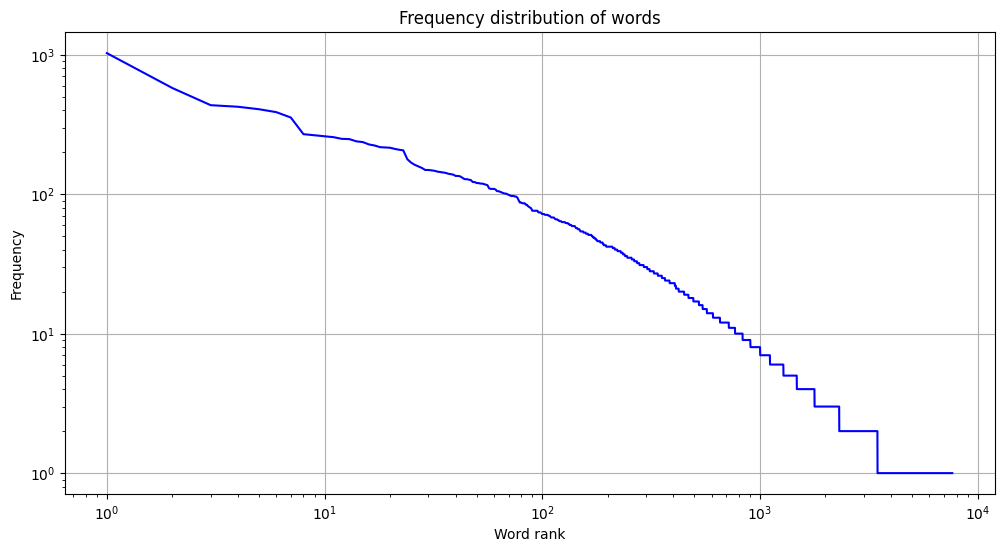

In [ ]:
visualize_words_frequency(X_train, BagOfWordsStem())

На графике видно, что существенный скачок в частоте и переход на более выраженную "лесенку" происходит примерно на 400 слове. Для выбора оптимального размера словаря можно рассматривать интервал от 300 до 800 слов.

In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, BagOfWordsStem, LogisticRegression(), range(300, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 25/25 [00:52<00:00,  2.09s/it]

Best size: 540, Best score: 0.992831541218638


In [ ]:
# Подберите оптимальный размер словаря


bow = BagOfWordsStem(vocabulary_size=540, ignore_stopwords=True, remove_stopwords=True)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((5016, 540), (558, 540))

In [ ]:
model = LogisticRegression()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       483
        spam       1.00      0.95      0.97        75

    accuracy                           0.99       558
   macro avg       1.00      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



## TF-IDF (2 балла)

Доработайте предыдущий класс до полноценного Tf-Idf, затем, аналогично, проведите эксперименты с логистической регрессией.

In [ ]:
class TFIDFVectorizer:
    def __init__(
        self,
        vocabulary_size: int,
        language: str = "english",
        ignore_stopwords: bool = True,
        remove_stopwords: bool = True,
        use_idf: bool = False,
    ):
        self._vocabulary_size = vocabulary_size
        self._vocabulary = None
        self._idf = None
        self._use_idf = use_idf

        if remove_stopwords and not ignore_stopwords:
            raise ValueError("To remove stop-words they should be ignored by stemmer")
        self._stemmer = SnowballStemmer(language, ignore_stopwords=ignore_stopwords)
        self._stopwords = stopwords.words(language)
        self._remove_stopwords = remove_stopwords

    def _tokenize(self, sentence: str) -> list[str]:
        sentence = re.sub(r'[^\w\s]', '', sentence.lower())
        tokens = sentence.split()

        if self._remove_stopwords:
            tokens = [token for token in tokens if token not in self._stopwords]

        stemmed_tokens = [self._stemmer.stem(token) for token in tokens]

        return stemmed_tokens

    def fit(self, sentences: list[str]):
        """Build vocabulary and compute IDF"""
        n_docs = len(sentences)
        corpus_token_counts = Counter()
        document_token_counts = defaultdict(int)

        for sentence in sentences:
            tokens = self._tokenize(sentence)
            corpus_token_counts.update(tokens)

            for token in set(tokens):
                document_token_counts[token] += 1

        most_common_tokens = corpus_token_counts.most_common(self._vocabulary_size)
        self._vocabulary = {token: idx for idx, (token, count) in enumerate(most_common_tokens)}

        if self._use_idf:
            self._idf = {}
            for token in self._vocabulary.keys():
                df = document_token_counts.get(token, 0)
                self._idf[token] = math.log((n_docs + 1) / (df + 1)) + 1

    def transform(self, sentences: list[str]) -> np.ndarray:
        """Transform sentences to TF-IDF vectors"""
        if self._vocabulary is None:
            raise RuntimeError("Fit the vectorizer first.")

        vectors = np.zeros((len(sentences), len(self._vocabulary)))

        for i, doc in enumerate(sentences):
            tokens = self._tokenize(doc)
            token_counts = Counter(tokens)
            doc_len = len(tokens)

            for token, count in token_counts.items():
                if token in self._vocabulary:
                    idx = self._vocabulary[token]
                    tf = count

                    if self._use_idf:
                        vectors[i, idx] = tf * self._idf[token]
                    else:
                        vectors[i, idx] = tf

        return vectors

    def fit_transform(self, sentences: list[str]) -> np.ndarray:
        self.fit(sentences)
        return self.transform(sentences)

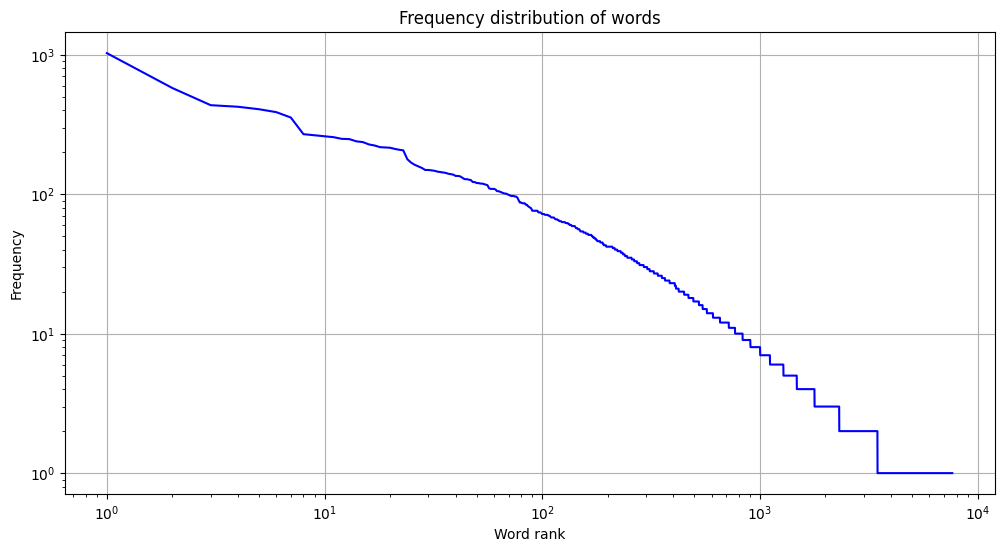

In [ ]:
visualize_words_frequency(X_train, TFIDFVectorizer(vocabulary_size=1000))

Видно, что существенный скачок частоты происходит примерно на 400 слове. Поэтому для оптимального размера словаря подойдут значения из интервала от 300 до 800 слов.

In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, TFIDFVectorizer, LogisticRegression(), range(300, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 25/25 [00:55<00:00,  2.24s/it]

Best size: 540, Best score: 0.992831541218638


In [ ]:
# Подберите оптимальный размер словаря


tfidf = TFIDFVectorizer(vocabulary_size=540, remove_stopwords=True, use_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((5016, 540), (558, 540))

In [ ]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       483
        spam       0.94      0.96      0.95        75

    accuracy                           0.99       558
   macro avg       0.96      0.97      0.97       558
weighted avg       0.99      0.99      0.99       558



## NaiveBayes (5 баллов)

Наивный байесовский классификатор — это простой и эффективный алгоритм машинного обучения, основанный на теореме Байеса с наивным предположением независимости признаков.

### Формула Байеса

$$
P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$

В контексте классификации текста это значит: $P(класс | документ) \propto P(класс) \cdot P(документ | класс)$

Почему "наивность"? Потому что предпологаем, что все слова независимы:

$$
P(w_1, w_2, \dots | class) = P(w_1 | class) \cdot P(w_2 | class) \cdot \dots
$$

### Классификация текста

Таким образом, для классификации текста необходимо:

1. Вычислить априорную вероятность класса: $P(class)$, доля документов с таким классом
2. Вычислить правдоподобие: $P(text | class) = \prod_{i=1}^n P(w_i | class)$

_Примечание:_ $P(w_i | class)$ — это частота слова в данном классе относительно всех слов в классе, при этом зачастую добавляют сглаживание Лапласа в качестве регуляризатора
$$
P(w_i | class) = \frac{\text{частота слова в классе} + \alpha}{\text{сумма всех слов в классе} + \alpha \cdot |V|}
$$

После этого, необходимо выбрать наиболее вероятный класс для данного текста:

$$
class = \arg \max\limits_{c} \Big[ P(c) \cdot P(text | c) \Big] = \arg \max\limits_{c} \Big[ \log P(c) + \sum_{i=1}^n \log P(w_i | c) \Big]
$$

### Реализация

`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`.

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу.

In [ ]:
class NaiveBayes:

    def __init__(self, alpha: float = 1.0):
        """
        Args:
            alpha: regularization coefficient
        """
        self.alpha = alpha
        self._classes = None  # [n classes]
        self._vocab_size = None  # int
        self._log_p_y = None  # [n classes]
        self._log_p_x_y = None  # [n classes, vocab size]

    def fit(self, features: np.ndarray, targets: list[str]):
        """Estimate p(x|y) and p(y) based on data

        Args:
            features, [n samples; vocab size]: input features
            targets, [n samples]: targets
        """
        targets = np.array(targets)

        self._classes = np.unique(targets)
        n_classes = len(self._classes)
        self._vocab_size = features.shape[1]

        class_counts = np.array([(targets == c).sum() for c in self._classes])
        self._log_p_y = np.log(class_counts / len(targets))

        self._log_p_x_y = np.zeros((n_classes, self._vocab_size))

        for i, c in enumerate(self._classes):
            class_features = features[targets == c]

            word_counts = class_features.sum(axis=0)
            total_words = word_counts.sum()

            self._log_p_x_y[i] = np.log(
                (word_counts + self.alpha) /
                (total_words + self.alpha * self._vocab_size)
            )

    def predict(self, features: np.ndarray) -> np.ndarray:
        """Predict class for each sample

        Args:
            features, [n samples; vocab size]: feature to predict
        Return:
            classes, [n samples]: predicted class
        """
        return self._classes[np.argmax(self.log_proba(features), axis=1)]

    def log_proba(self, features: np.ndarray) -> np.ndarray:
        """Calculate p(y|x) for each class and each sample

        Args:
            features, [n samples; vocab size]: feature to predict
        Return:
            classes, [n samples;  n classes]: log proba for each class
        """
        if self._vocab_size is None:
            raise RuntimeError("Fit classifier before predicting something")
        if features.shape[1] != self._vocab_size:
            raise RuntimeError(
                f"Unexpected size of vocabulary, expected {self._vocab_size}, actual {features.shape[1]}"
            )

        log_p_x_y = features @ self._log_p_x_y.T

        log_joint = self._log_p_y + log_p_x_y

        log_norm = np.logaddexp.reduce(log_joint, axis=1, keepdims=True)

        return log_joint - log_norm

In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, BagOfWordsStem, NaiveBayes(alpha=1.0), range(300, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 25/25 [00:40<00:00,  1.63s/it]

Best size: 520, Best score: 0.978494623655914


In [ ]:
# Подберите оптимальный размер словаря


bow = BagOfWordsStem(vocabulary_size=520, remove_stopwords=True)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((5016, 520), (558, 520))

In [ ]:
model = NaiveBayes(alpha=1.0)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       483
        spam       0.88      0.97      0.92        75

    accuracy                           0.98       558
   macro avg       0.94      0.98      0.96       558
weighted avg       0.98      0.98      0.98       558



In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, BagOfWords, NaiveBayes(alpha=1.0), range(300, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 25/25 [00:04<00:00,  5.47it/s]


Best size: 740, Best score: 0.9910394265232975


In [ ]:
bow = BagOfWords(vocabulary_size=740)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((5016, 740), (558, 740))

In [ ]:
model = NaiveBayes(alpha=1.0)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       483
        spam       0.96      0.97      0.97        75

    accuracy                           0.99       558
   macro avg       0.98      0.98      0.98       558
weighted avg       0.99      0.99      0.99       558



In [ ]:
results = find_optimal_vocab_size(X_train, y_train, X_test, y_test, TFIDFVectorizer, NaiveBayes(alpha=1.0), range(300, 800, 20))
print(f"Best size: {results['best_size']}, Best score: {results['best_score']}")

100%|██████████| 25/25 [00:43<00:00,  1.75s/it]

Best size: 520, Best score: 0.978494623655914


In [ ]:
tfidf = TFIDFVectorizer(vocabulary_size=520, remove_stopwords=True, use_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((5016, 520), (558, 520))

In [ ]:
model = NaiveBayes(alpha=1.0)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97       483
        spam       0.77      0.97      0.86        75

    accuracy                           0.96       558
   macro avg       0.88      0.96      0.92       558
weighted avg       0.97      0.96      0.96       558



**Вывод:** Наилучшие результаты байесовский классификатор показал с обычным BagOfWords